# 프로젝트 : 네이버 영화리뷰 감성분석

* 데이터셋 : 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc) 

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


## 2) 데이터로더 구성
* 데이터의 중복 제거
* `NaN` 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전`word_to_index` 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

### 데이터의 중복 제거, NaN 결측치 제거

In [3]:
def remove_duplicates_and_missing_values(df,subset,nan_how='any'):
    
    # 중복 제거 : DataFrame의 `drop_duplicates`사용 
    #   * subset : 'document'컬럼에 적용
    #   * inpace : 변경사항을 원본데이터(train_data)에 적용
    df.drop_duplicates(subset=[subset], inplace=True)

    # 결측값 제거 : DataFrame의 `dropna`사용 
    #   * how : 'any' : 존재하면 제거 / 'all' : 모두 결측치면 제거
    df = df.dropna(how = nan_how)
    return df

### 한국어 토크나이저로 토큰화

In [4]:
def ko_tokenize_sentences(df, tokenizer, subset):
    
    tokenized_sentences = []
    for sentence in df[subset]:
        tokenized_sentences.append(tokenizer.morphs(sentence)) # morphs : 형태소 추출
    return tokenized_sentences

### 불용어(Stopwords) 제거

In [5]:
def remove_stopwords(tokens, stopwords):
    
    filtered_tokens = []
    for token in tokens:
        if token not in stopwords: # stopwords에 없는 token만 저장
            filtered_tokens.append(token)
            
    return filtered_tokens

In [6]:
def load_data(train_data, test_data, num_words=10000):

    # 데이터의 중복 제거, NaN 결측치 제거
    train_data = remove_duplicates_and_missing_values(train_data,subset='document',nan_how='any')
    test_data = remove_duplicates_and_missing_values(test_data,subset='document',nan_how='any')

    
    # 한국어 토크나이저로 토큰화
    train_tokens_data = ko_tokenize_sentences(train_data, tokenizer, subset='document')
    test_tokens_data = ko_tokenize_sentences(test_data, tokenizer, subset='document')

    
    # 불용어(Stopwords) 제거
    train_tokens_data = remove_stopwords(train_tokens_data, stopwords)
    test_tokens_data = remove_stopwords(test_tokens_data, stopwords)
    
    # 문장단위로 저장되어있는 token드을 합치고 list로 저장
    words = np.concatenate(train_tokens_data).tolist() 

    # 가장 많이 나온 단어순으로 출력할 단어수 저장(<PAD>, <BOS>, <UNK>, <UNUSED> 가 0,1,2,3에 들어감)
    counter = Counter(words).most_common(num_words-4) 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, train_tokens_data))
    X_test = list(map(wordlist_to_indexlist, test_tokens_data))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

vocab_size = 20000
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, vocab_size) 

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  18.72297390690031
문장길이 최대 :  116
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  49
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 49)


## 4) 모델 구성 및 validation set 구성
* 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [10]:
from tensorflow.keras.initializers import Constant

word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_CNN.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 32)            640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 43, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 647,473
Trainable params: 647,473
Non-trainable params: 0
_________________________________________________________________


In [11]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTM.add(tf.keras.layers.LSTM(16))
model_LSTM.add(tf.keras.layers.Dropout(0.2))
model_LSTM.add(tf.keras.layers.Dense(8, activation='sigmoid')) 
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 49, 32)            640000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 643,281
Trainable params: 643,281
Non-trainable params: 0
_________________________________________________________________


In [12]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_GRU = tf.keras.Sequential()
model_GRU.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_GRU.add(tf.keras.layers.GRU(16))
model_GRU.add(tf.keras.layers.Dropout(0.2))
model_GRU.add(tf.keras.layers.Dense(8, activation='sigmoid')) 
model_GRU.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 49, 32)            640000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 643,281
Trainable params: 643,281
Non-trainable params: 0
_________________________________________________________________


In [13]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_FNN = tf.keras.Sequential()
model_FNN.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_FNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_FNN.add(tf.keras.layers.Dense(128, activation='relu'))
model_FNN.add(tf.keras.layers.Dropout(0.5))
model_FNN.add(tf.keras.layers.Dense(64, activation='relu'))
model_FNN.add(tf.keras.layers.Dropout(0.5))
model_FNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_FNN.add(tf.keras.layers.Dropout(0.5))
model_FNN.add(tf.keras.layers.Dense(16, activation='relu'))
model_FNN.add(tf.keras.layers.Dropout(0.5))
model_FNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_FNN.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_FNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 49, 128)           2560000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

### LSTM+GRU

In [14]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_LSTMGRU = tf.keras.Sequential()
model_LSTMGRU.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTMGRU.add(tf.keras.layers.LSTM(16, return_sequences = True))
model_LSTMGRU.add(tf.keras.layers.Dropout(0.5))
model_LSTMGRU.add(tf.keras.layers.GRU(16))
model_LSTMGRU.add(tf.keras.layers.Dense(8, activation='relu'))
model_LSTMGRU.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_LSTMGRU.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 49, 16)            320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 49, 16)            2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 16)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 323,889
Trainable params: 323,889
Non-trainable params: 0
________________________________________________

In [15]:
val_data_rate = 0.2
val_data_num = int(X_train.shape[0]*val_data_rate)

# validation set 10000건 분리
x_val = X_train[:val_data_num]   
y_val = y_train[:val_data_num]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[val_data_num:]  
partial_y_train = y_train[val_data_num:]

print(partial_x_train.shape)
print(x_val.shape)

(116946, 49)
(29236, 49)


## 5) 모델 훈련 개시
* `model_CNN`, `model_LSTM`, `model_GRU`, `model_FNN` 네가지 모델로 진행

### CNN 

In [16]:
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_CNN = model_CNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)
print('model_CNN 학습 완료')

model_CNN 학습 완료


### LSTM

In [17]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10

history_LSTM = model_LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)
print('model_LSTM 학습 완료')

model_LSTM 학습 완료


### GRU

In [18]:
model_GRU.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_GRU = model_GRU.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)
print('model_GRU 학습 완료')

model_GRU 학습 완료


### FNN

In [19]:
model_FNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  

history_FNN = model_FNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)
print('model_FNN 학습 완료')

model_FNN 학습 완료


### LSTM+GRU

In [20]:
model_LSTMGRU.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_LSTMGRU = model_LSTMGRU.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)
print('model_LSTMGRU 학습 완료')

model_LSTMGRU 학습 완료


## 6) Loss, Accuracy 그래프 시각화

In [21]:
import matplotlib.pyplot as plt

def show_loss_acc_graph(loss, acc,val_loss, val_acc, epochs, graph_title='Loss and Accuracy'):

    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    
    ax[0].plot(epochs, loss, 'b--', label='Training loss')
    ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, acc, 'b--', label='Training acc')
    ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    fig.suptitle(graph_title, fontsize=16)

    plt.show()

### CNN

1537/1537 - 3s - loss: 0.5605 - accuracy: 0.8342
[0.5604722499847412, 0.834225058555603]


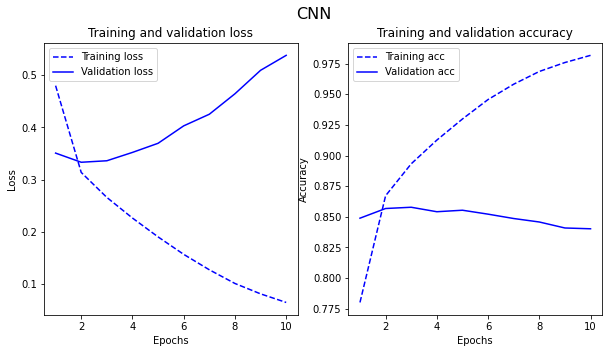

In [22]:
results = model_CNN.evaluate(X_test,  y_test, verbose=2)
print(results)

history_CNN_dict = history_CNN.history
acc = history_CNN_dict['accuracy']
val_acc = history_CNN_dict['val_accuracy']
loss = history_CNN_dict['loss']
val_loss = history_CNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

show_loss_acc_graph(loss, acc, val_loss, val_acc, epochs, graph_title='CNN')

### LSTM

1537/1537 - 3s - loss: 0.4305 - accuracy: 0.8429
[0.4304725229740143, 0.8429114818572998]


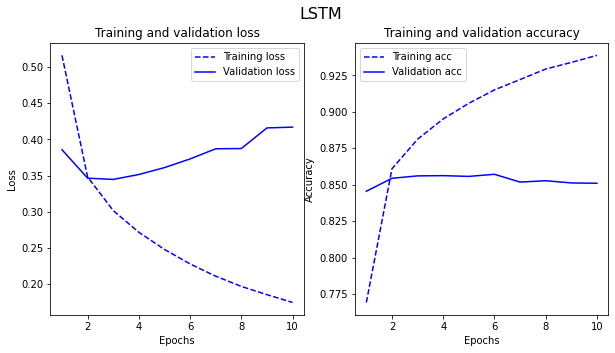

In [23]:
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

history_LSTM_dict = history_LSTM.history
acc = history_LSTM_dict['accuracy']
val_acc = history_LSTM_dict['val_accuracy']
loss = history_LSTM_dict['loss']
val_loss = history_LSTM_dict['val_loss']
epochs = range(1, len(acc) + 1)

show_loss_acc_graph(loss,acc,val_loss,val_acc,epochs, graph_title='LSTM')

### GRU

1537/1537 - 3s - loss: 0.4252 - accuracy: 0.8395
[0.4251866936683655, 0.8394735455513]


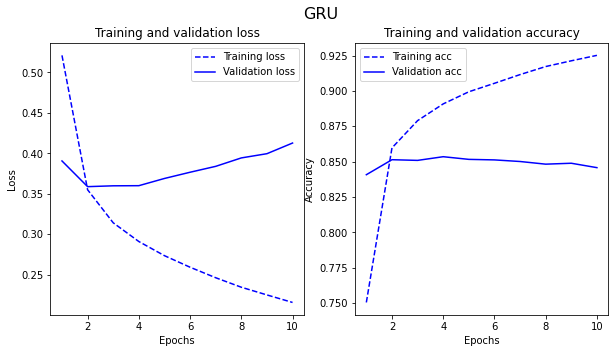

In [24]:
results = model_GRU.evaluate(X_test,  y_test, verbose=2)
print(results)

history_GRU_dict = history_GRU.history
acc = history_GRU_dict['accuracy']
val_acc = history_GRU_dict['val_accuracy']
loss = history_GRU_dict['loss']
val_loss = history_GRU_dict['val_loss']
epochs = range(1, len(acc) + 1)

show_loss_acc_graph(loss,acc,val_loss,val_acc,epochs, graph_title='GRU')

### FNN

1537/1537 - 2s - loss: 1.2639 - accuracy: 0.8236
[1.2639011144638062, 0.8235856294631958]


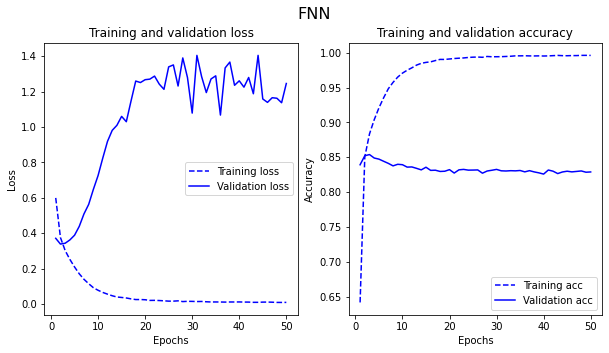

In [25]:
results = model_FNN.evaluate(X_test,  y_test, verbose=2)
print(results)

history_FNN_dict = history_FNN.history
acc = history_FNN_dict['accuracy']
val_acc = history_FNN_dict['val_accuracy']
loss = history_FNN_dict['loss']
val_loss = history_FNN_dict['val_loss']
epochs = range(1, len(acc) + 1)

show_loss_acc_graph(loss,acc,val_loss,val_acc,epochs, graph_title='FNN')

## LSTM+GRU

1537/1537 - 5s - loss: 0.4270 - accuracy: 0.8397
[0.4270135462284088, 0.8397176265716553]


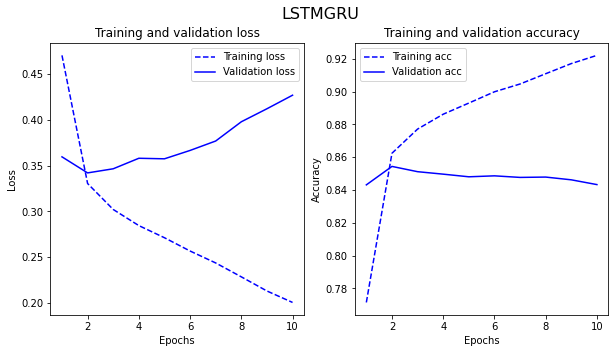

In [26]:
results = model_LSTMGRU.evaluate(X_test,  y_test, verbose=2)
print(results)

history_LSTMGRU_dict = history_LSTMGRU.history
acc = history_LSTMGRU_dict['accuracy']
val_acc = history_LSTMGRU_dict['val_accuracy']
loss = history_LSTMGRU_dict['loss']
val_loss = history_LSTMGRU_dict['val_loss']
epochs = range(1, len(acc) + 1)

show_loss_acc_graph(loss,acc,val_loss,val_acc,epochs, graph_title='LSTMGRU')

CNN 정확도 : 0.8260  
LSTM 정확도 : 0.8324  
GRU 정확도 : 0.8357  
FNN 정확도 : 0.8228  

다음과 같다. 모든 결과들이 validation loss가 상승하고 있다.  

1. epch를 20->10으로 줄임
2. 두가지 모델을 합쳐 진행.(LSTM+GRU)

CNN 정확도 : 0.8325    
LSTM 정확도 : 0.8431  
GRU 정확도 : 0.8411  
FNN 정확도 : 0.8232 (변경사항 없음)  
LSTM+GRU 정확도 : 0.8397  

전체적으로 정확도가 상승.

가장 잘나온 LSTM으로 아래의 내용을 진행.

## 7) 학습된 Embedding 레이어 분석

In [27]:
embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(20000, 32)


In [28]:
import os
word_vector_dim = 32

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec1.txt'

f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.


index_to_word = {index:word for word, index in word_to_index.items()}
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM.get_weights()[0]

for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [30]:
word_vectors.similar_by_word("별로")

[('재미없', 0.9736591577529907),
 ('쓰레기', 0.9700722694396973),
 ('지루함', 0.9699013829231262),
 ('졸작', 0.9664607644081116),
 ('비추', 0.9640833139419556),
 ('.,,.', 0.9624908566474915),
 ('더러워', 0.9583292603492737),
 ('구려', 0.9536016583442688),
 ('오징어', 0.9529984593391418),
 ('쓰래', 0.952909529209137)]

In [31]:
word_vectors.similar_by_word("엄청")

[('조직', 0.8789353966712952),
 ('대면', 0.8786836266517639),
 ('윌스미스', 0.8785145878791809),
 ('덮', 0.8742292523384094),
 ('명감독', 0.8685742020606995),
 ('웃겨서', 0.8681471943855286),
 ('한다는데', 0.8678939938545227),
 ('들인', 0.8659491539001465),
 ('탄광', 0.8641089797019958),
 ('탐정', 0.861352264881134)]

In [32]:
word_vectors.similar_by_word("재미")

[('매우', 0.8389867544174194),
 ('넘', 0.7888789772987366),
 ('공감', 0.7850881814956665),
 ('예쁜', 0.7739993929862976),
 ('번쩍', 0.7685191035270691),
 ('빠다', 0.7678638696670532),
 ('은대', 0.767718493938446),
 ('신비', 0.7583786845207214),
 ('모두', 0.7569824457168579),
 ('데이브', 0.7491564750671387)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 `load_word2vec_format()` 형태가 아닌 `load()` 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

```python
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]
```

In [33]:
import gensim
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_file_path)
# word2vec_file_path


In [34]:
word2vec.wv.similar_by_word("별로")

[('전혀', 0.6421527862548828),
 ('그다지', 0.6234328746795654),
 ('꽤', 0.6035930514335632),
 ('확실히', 0.5738269090652466),
 ('딱히', 0.5515185594558716),
 ('상당히', 0.542231023311615),
 ('볼일', 0.5412046313285828),
 ('다름', 0.531372606754303),
 ('별', 0.5228564739227295),
 ('확연히', 0.5193501710891724)]

In [35]:
word2vec.wv.similar_by_word("엄청")

[('정말', 0.7083098292350769),
 ('유난히', 0.7057230472564697),
 ('무척', 0.6932373046875),
 ('굉장히', 0.6931843161582947),
 ('너무', 0.6874515414237976),
 ('애교', 0.6703953146934509),
 ('워낙', 0.6617990732192993),
 ('몹시', 0.6547536849975586),
 ('너무나', 0.6382076144218445),
 ('우린', 0.6359992027282715)]

In [36]:
word2vec.wv.similar_by_word("재미")

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

In [37]:
vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [41]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation='sigmoid')) 
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 49, 100)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 2,017,569
Trainable params: 2,017,569
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)
print('model 학습 완료')

model 학습 완료


1537/1537 - 4s - loss: 0.3731 - accuracy: 0.8546
[0.37310898303985596, 0.8546493649482727]


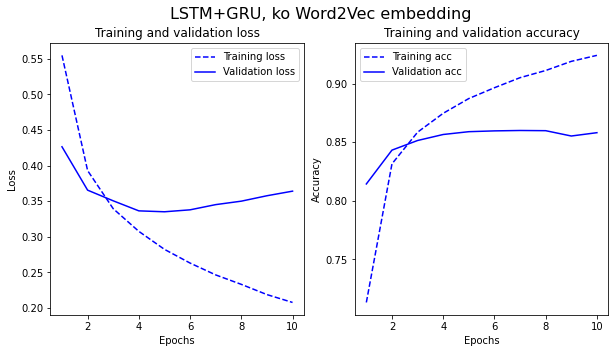

In [43]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

show_loss_acc_graph(loss,acc,val_loss,val_acc,epochs, graph_title='LSTM+GRU, ko Word2Vec embedding')